In [ ]:
# import json
# import _pickle as cPickle
# import boto3
# import io
# import pandas as pd

# session = boto3.session.Session()
# s3client = session.client('s3', config= boto3.session.Config(signature_version='s3v4'),aws_access_key_id='',
#          aws_secret_access_key='')

# response = s3client.get_object(Bucket='morty0112', Key='final_df_20180111.pkl')
# df_0 = pd.read_pickle(io.BytesIO(response['Body'].read()))

In [2]:
import pandas as pd
import numpy as np
import prework as pwk
import string
from time import time


from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import statsmodels as sm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
from gensim.models.doc2vec import LabeledSentence, Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

/Users/ziru/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import sys
stdout = sys.stdout

reload(sys)
sys.setdefaultencoding('utf-8')

sys.stdout = stdout

In [3]:
import spacy
spc_nlp = spacy.load('en')

**Add sytactic features from pickle file (syntactic feature generation takes a long time, so pickling is here to save some time)**

In [4]:
df_0 = pd.read_pickle('data/pickles/final_df_20180111.pkl')

In [5]:
df_0 = df_0.reset_index(drop=True)

In [6]:
'|||'.join(df_0.columns)

'doc_id|||path|||author_code|||essay_content|||label|||DT_max_dp_cnts|||DT_archs|||DT_ROOT_idx|||DT_pass_cnt|||DT_mark_cnt|||POS_adjv_body|||DT_pos|||DT_pos_join|||DT_archs_join|||unique_lemma|||avg_stc_length|||total_stc|||POS_adjv_repeat|||POS_adjv_repeat_sum|||doc2vec_lm_token'

**Generate lexical features**

In [9]:
#df_0['unique_lemma'] = df_0['essay_content'].apply(lambda x: len(set([token.lemma_ for token in spc_nlp(x.decode('utf-8')) if token.is_punct==False])))

In [10]:
#df_0['avg_stc_length'] = df_0['essay_content'].apply(lambda x: np.mean([len(s) for s in spc_nlp(x.decode('utf-8')).sents]))

In [11]:
#df_0['total_stc'] = df_0['essay_content'].apply(lambda x: len([s for s in spc_nlp(x.decode('utf-8')).sents]))

In [12]:
#'|||'.join(df_0.columns)

In [13]:
# Save the final dataframe to a pickle file as a backup
#df_0.to_pickle('final_df_20180111.pkl')

## Modeling Experiments

In [5]:
df_0.head(2)

,doc_id,path,author_code,essay_content,label,DT_max_dp_cnts,DT_archs,DT_ROOT_idx,DT_pass_cnt,DT_mark_cnt,POS_adjv_body,DT_pos,DT_pos_join,DT_archs_join,unique_lemma,avg_stc_length,total_stc
0,1,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_021_A2_0.txt,﻿I agree that it is important for college stud...,CHN,"[4, 6, 6, 8, 8, 5, 4, 6, 8, 4, 5, 7, 6]",[nsubj ROOT mark nsubj ccomp acomp mark compou...,"[1, 9, 3, 16, 8, 8, 1, 3, 7, 1, 11, 2, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]","[apart, nowadays, large, well, many, when, the...",[NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PAR...,NOUN VERB ADP PRON VERB ADJ ADP NOUN NOUN PART...,nsubj ROOT mark nsubj ccomp acomp mark compoun...,94,19.538462,13
1,2,data/ICNALE/Unmerged_classified/ICNALE_W_CHN_A...,W_CHN_PTJ0_022_A2_0.txt,"﻿In the last years, college students taking a ...",CHN,"[7, 4, 4, 3, 5, 5, 5, 5, 4, 6, 6, 7, 8, 9]",[aux det amod npadvmod punct compound nsubj ac...,"[13, 2, 2, 1, 3, 6, 8, 5, 2, 3, 2, 4, 11, 4]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 2, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0]","[last, very, big, many, firstly, most, importa...",[VERB DET ADJ NOUN PUNCT NOUN NOUN VERB DET AD...,VERB DET ADJ NOUN PUNCT NOUN NOUN VERB DET ADJ...,aux det amod npadvmod punct compound nsubj acl...,100,16.714286,14


### Make classes balanced

In [7]:
from numpy.random import choice
cond = (df_0['label']=='CHN')
idx_remove = list(choice(df_0[cond].index, 400, replace=False))
cond = (df_0['label']=='JPN')
idx_remove += list(choice(df_0[cond].index, 400, replace=False))
cond = (df_0['label']=='KOR')
idx_remove += list(choice(df_0[cond].index, 200, replace=False))
cond = (df_0['label']=='THA')&(df_0['avg_stc_length']<31)
idx_remove += list(choice(df_0[cond].index, 400, replace=False))

In [8]:
len(idx_remove)

1400

In [9]:
#idx_remove
df_1 = df_0.drop(df_0.index[idx_remove])

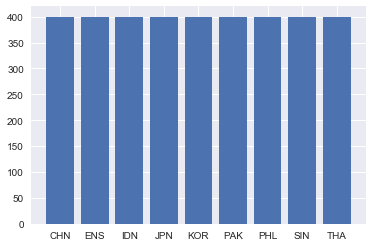

In [10]:
countries = list(df_1.groupby('label').size().index)
sample_count = df_1.groupby('label').size().values
fig, ax = plt.subplots()
ax.bar(range(len(countries)), sample_count)
#ax.xticks = countries
plt.xticks(range(len(countries)), countries)
#fig.set_size_inches(18.5, 10.5, forward=True)
fig.show()

In [8]:
pd.set_option('display.max_colwidth', -1)

In [13]:
df_0[df_0['label']=='ENS'][['essay_content','DT_pos','DT_archs']][3:4]

,essay_content,DT_pos,DT_archs
803,"﻿It was important for me because it allowed me to take time off and travel to Japan. I know that some of my friends work because they wanted the money for student fees and books etc. At first, I had the same plan as they did but as time went on I found that I was losing interest in studying and always tired. So instead of just working to study, I decided to save some of the money for travel, take a short break and then return to my studies feeling refreshed and like I had done something for myself. I know that studying is worthwhile and I will finish my degree but I have also been studying for most of my life and felt like I needed a break. It has been great so far and I don't regret my decision one bit. My old man (father) wasn't too impressed with the idea though and tried to talk me out of it with these long boring lectures. Finally, I just decided to go ahead and do it and I am glad I did. So, I think that it is important for college students to work part-time because it gives them the freedom to either do as I did or just the cash to relax a bit more in style after so many years of study, study, study.","[PROPN VERB ADJ ADP PRON ADP PRON VERB PRON PART VERB NOUN PART CCONJ VERB ADP PROPN PUNCT, PRON VERB ADP DET ADP ADJ NOUN VERB ADP PRON VERB DET NOUN ADP NOUN NOUN CCONJ NOUN X PUNCT, ADP ADV PUNCT PRON VERB DET ADJ NOUN ADP PRON VERB, CCONJ ADP NOUN VERB ADP PRON VERB ADP PRON VERB VERB NOUN ADP VERB CCONJ ADV ADJ PUNCT, ADV ADV ADP ADV VERB PART VERB PUNCT PRON VERB PART VERB DET ADP DET NOUN ADP NOUN PUNCT VERB DET ADJ NOUN CCONJ ADV VERB ADP ADJ NOUN NOUN VERB CCONJ INTJ PRON VERB VERB NOUN ADP PRON PUNCT, PRON VERB ADP VERB VERB ADJ CCONJ PRON VERB VERB ADJ NOUN, CCONJ PRON VERB ADV VERB VERB ADP ADJ ADP ADJ NOUN CCONJ VERB ADP PRON VERB DET NOUN PUNCT, PRON VERB VERB ADJ ADV ADV, CCONJ PRON VERB ADV VERB ADJ NOUN NUM NOUN PUNCT, ADJ ADJ NOUN PUNCT NOUN PUNCT VERB ADV ADV ADJ ADP DET NOUN ADV CCONJ VERB PART VERB PRON ADP ADP PRON ADP DET ADJ ADJ NOUN PUNCT, ADV PUNCT PRON ADV VERB PART VERB ADV CCONJ VERB PRON, CCONJ PRON VERB ADJ PRON VERB PUNCT, CCONJ PUNCT PRON VERB ADP PRON VERB ADJ ADP NOUN NOUN PART VERB NOUN PUNCT NOUN ADP PRON VERB PRON DET NOUN PART CCONJ VERB ADP PRON VERB CCONJ ADV DET NOUN PART VERB DET NOUN ADV ADP NOUN ADP ADV ADJ NOUN ADP NOUN PUNCT NOUN PUNCT NOUN PUNCT]","[nsubj ROOT acomp prep pobj mark nsubj advcl nsubj aux ccomp dobj prt cc conj prep pobj punct, nsubj ROOT mark nsubj prep poss pobj ccomp mark nsubj advcl det dobj prep compound pobj cc compound conj punct, prep pcomp punct nsubj ROOT det amod dobj mark nsubj advcl, cc mark nsubj advcl prep nsubj ROOT mark nsubj aux ccomp dobj prep pcomp cc advmod conj punct, advmod advmod prep advmod pcomp aux xcomp punct nsubj ROOT aux xcomp dobj prep det pobj prep pobj punct conj det amod dobj cc advmod conj prep poss pobj advcl acomp cc mark nsubj aux conj dobj dative pobj punct, nsubj ROOT mark csubj ccomp acomp cc nsubj aux conj poss dobj, cc nsubj aux advmod aux ROOT prep pobj prep poss pobj cc conj mark nsubj advcl det dobj punct, nsubj aux ROOT acomp advmod advmod, cc nsubj aux neg ROOT poss dobj nummod npadvmod punct, poss amod nsubj punct appos punct ROOT neg advmod acomp prep det pobj advmod cc conj aux xcomp dobj prep prep pobj prep det amod amod pobj punct, advmod punct nsubj advmod ROOT aux xcomp advmod cc conj dobj, cc nsubj ROOT acomp nsubj ccomp punct, advmod punct nsubj ROOT mark nsubj ccomp acomp mark compound nsubj aux advcl compound punct dobj mark nsubj advcl dative det dobj aux preconj relcl mark nsubj advcl cc advmod det conj aux relcl det npadvmod advmod prep pobj prep advmod amod pobj prep nmod punct nmod punct pobj punct]"


### More detailed EDA on these three features:

#### Essay Vocabulary

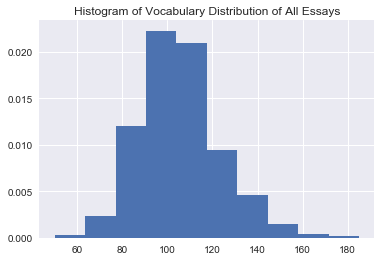

In [18]:
plt.hist(df_1['unique_lemma'], bins = 10, normed=1)
plt.title('Histogram of Vocabulary Distribution of All Essays')
plt.show()

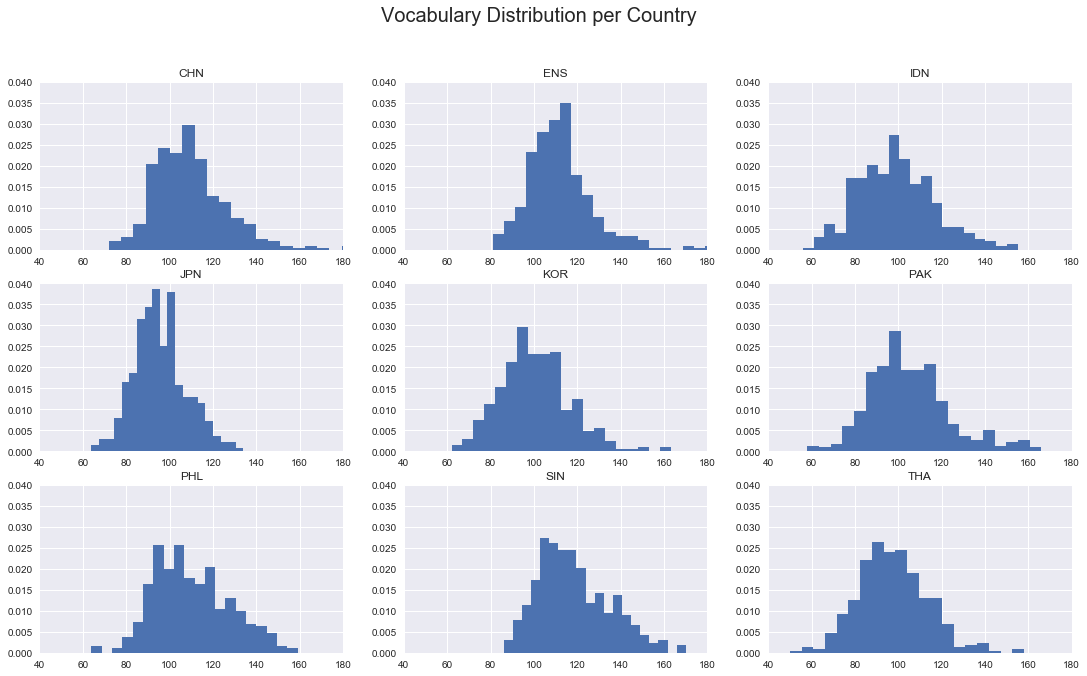

In [19]:
#cnry = ['CHN', 'ENS']
countries = list(df_1.groupby('label').size().index)
fig, axs = plt.subplots(3,3)
for c, ax in zip(countries, axs.flatten()):
    data = df_1[df_1['label']==c]['unique_lemma']
    ax.hist(data, bins=20, normed=1)
    ax.set_xlim(40, 180)
    ax.set_ylim(0, 0.04)
    ax.set_title(c)
fig.suptitle('Vocabulary Distribution per Country', fontsize=20)
fig.set_size_inches(18.5, 10.5, forward=True)

**Plotting vocabulary histogram by country to some degree explained the poor performance of the logistic regression model: there is not significant difference between countries on writers' vocabulary**

*Although interestingly, the distribution is slightly skewed to the left (lower vocabulary) for writers from **Indonesia**, and it is slightly skewed to the right (higher vocabulary) for writers from* **Pakistan**

#### Essay Sentence Count

In [20]:
np.percentile(df_1['total_stc'], 5)

7.9500000000000171

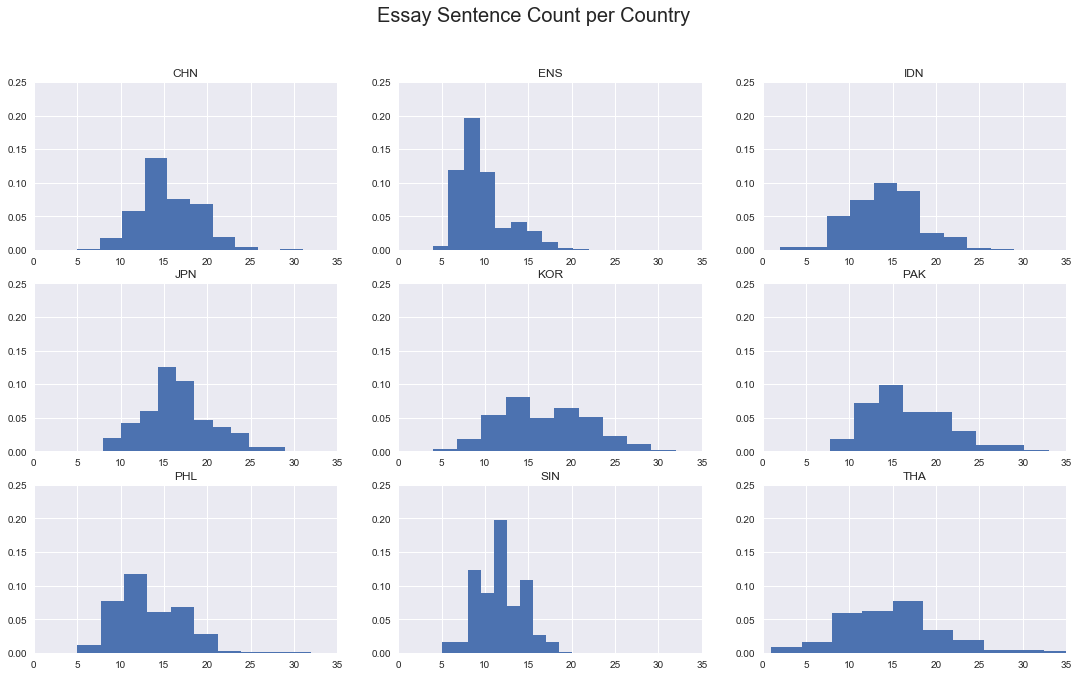

In [21]:
countries = list(df_1.groupby('label').size().index)
fig, axs = plt.subplots(3,3)
for c, ax in zip(countries, axs.flatten()):
    data = df_1[df_1['label']==c]['total_stc']
    ax.hist(data, bins=10, normed=1)
    ax.set_xlim(0, 35)
    ax.set_ylim(0, 0.25)
    ax.set_title(c)
fig.suptitle('Essay Sentence Count per Country', fontsize=20)
fig.set_size_inches(18.5, 10.5, forward=True)

**Although the distributions are still pretty normal, essay sentence counts shows bigger difference among countries compared to essay vocabulary. E.g. native speakers' essays tend to contain less sentences, and it makes sense. Native speakers are able to use English more efficiently compare to English learners. Take learners from Japan and Korea for example, the means of sentence count are higher then native speaker group, indicating more sentences for the same given essay topic.**

*One interesting finding is that learners from **Thailand** tend to write less sentences, too! This observation led to further investigation demonstrated later in this notebook*

#### Essay Average Sentence Length

In [22]:
np.percentile(df_1['avg_stc_length'], 95)

32.428571428571431

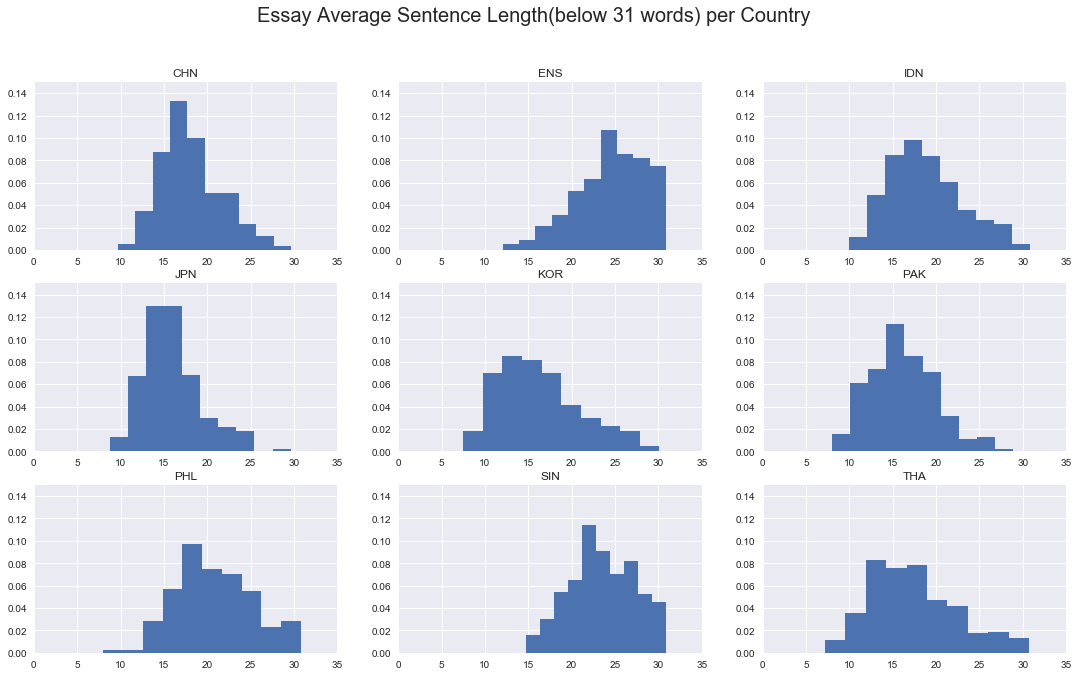

In [23]:
countries = list(df_1.groupby('label').size().index)
fig, axs = plt.subplots(3,3)
for c, ax in zip(countries, axs.flatten()):
    data = df_1[(df_1['label']==c)&(df_1['avg_stc_length']<31)]['avg_stc_length']
    ax.hist(data, bins=10, normed=1)
    ax.set_xlim(0, 35)
    ax.set_ylim(0, 0.15)
    ax.set_title(c)
fig.suptitle('Essay Average Sentence Length(below 31 words) per Country', fontsize=20)
fig.set_size_inches(18.5, 10.5, forward=True)

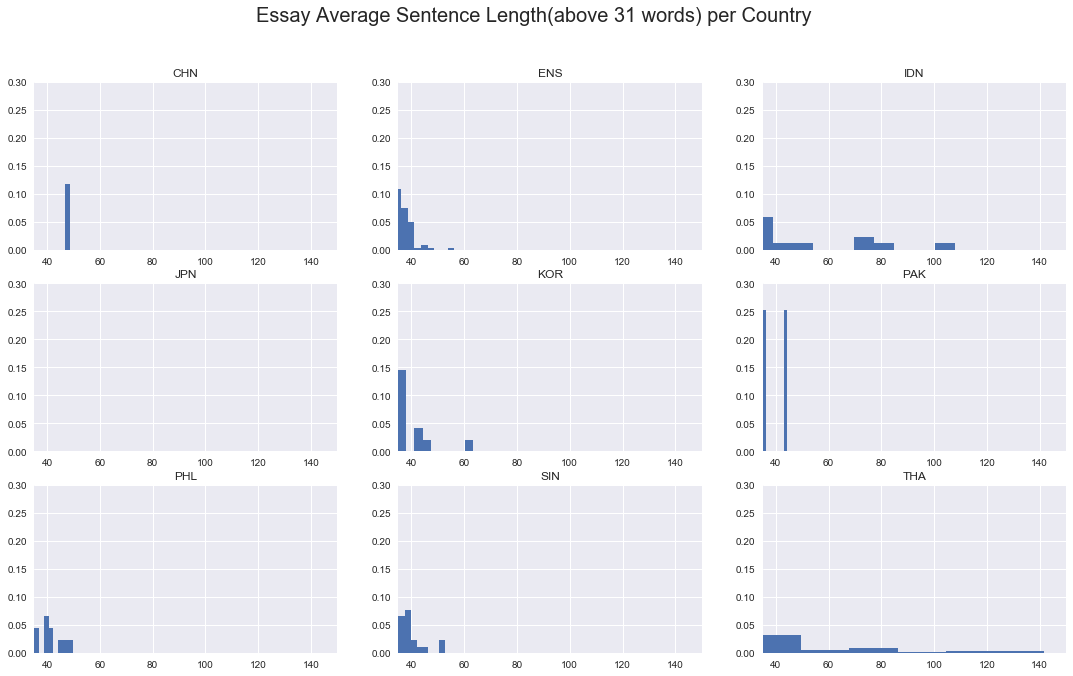

In [24]:
countries = list(df_1.groupby('label').size().index)
fig, axs = plt.subplots(3,3)
for c, ax in zip(countries, axs.flatten()):
    data = df_1[(df_1['label']==c)&(df_1['avg_stc_length']>31)]['avg_stc_length']
    ax.hist(data, bins=10, normed=1)
    ax.set_xlim(35, 150)
    ax.set_ylim(0, 0.3)
    ax.set_title(c)
fig.suptitle('Essay Average Sentence Length(above 31 words) per Country', fontsize=20)
fig.set_size_inches(18.5, 10.5, forward=True)

**I decided to plot average sentence length(word count) using the 95 percentile word count(31) as a threshold. As shown in the first figure, most countries have normal distribution with slight skew. Native speaker group is the only one that shows a large cutoff on the right side, indicating that average sentence length for this group tend to be larger.**

**The second part of the plot shows something very interesting about learners in Thailand. It shows a wide spread over high sentence length, which indicates that Thai learners tend to not  use a full stop often. This is to some degree influenced by their native language. The Thai script doesn't use a full stop at all**

### Sentence length vs sentence count

**For standardized English tests, there is a word count requirement for the essay. Therefore, it would make sense if the sentence length and sentence count are inversely correlated**

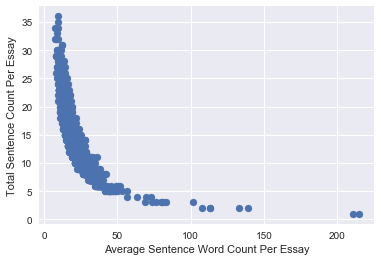

In [16]:
fig,ax = plt.subplots()
ax.scatter(df_1['avg_stc_length'], df_1['total_stc'])
ax.set_xlabel('Average Sentence Word Count Per Essay')
ax.set_ylabel('Total Sentence Count Per Essay')
plt.show()

**Now examine the two variables in each country group**

In [26]:
# Examine the actual long essay writing of Thai learners
pd.set_option('display.max_colwidth', -1)
df_1[(df_1['total_stc']<8)&(df_0['label']=='THA')]['path']

4210    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_035_A2_0.txt
4231    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_097_A2_0.txt
4236    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_116_A2_0.txt
4240    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_125_A2_0.txt
4241    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_127_A2_0.txt
4249    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_147_A2_0.txt
4263    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_178_A2_0.txt
4265    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_PTJ0_180_A2_0.txt
4320    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_SMK0_008_A2_0.txt
4336    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_SMK0_054_A2_0.txt
4349    data/ICNALE/Unmerged_classified/ICNALE_W_THA_A2_0_N238/W_THA_SMK0_093_A2_0.txt
4355    data/ICNALE/Unmerged_classified/ICN

In [17]:
# Using 95 percentile
df_ave_stc_31plus = df_1[df_1['avg_stc_length']>31]
df_ave_stc_31plus.groupby(['label']).size()

label
CHN     5
ENS    95
IDN    11
KOR    15
PAK     3
PHL    24
SIN    42
THA    42
dtype: int64

In [18]:
# Using 5 percentile
df_sent_less8 = df_1[(df_1['label']!='JPN')&(df_1['total_stc']<8)]
df_sent_less8.groupby(['label']).size()

label
CHN     2
ENS    90
IDN     9
KOR    10
PAK     1
PHL    13
SIN    20
THA    35
dtype: int64

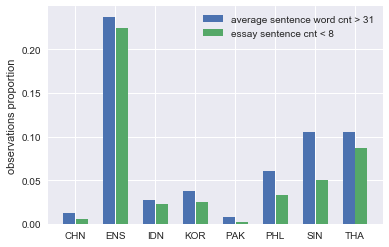

In [57]:
countries_1 = list(df_ave_stc_31plus.groupby(['label']).size().index)
word_cnt = df_ave_stc_31plus.groupby(['label']).size().values
sent_cnt = df_sent_less8.groupby(['label']).size().values
essay_cnt_country = df_1[df_1['label']!='JPN'].groupby(['label']).size().values
#essay_cnt_country = df_0.groupby(['label']).size().values

fig, ax = plt.subplots()
ax.bar(np.arange(len(countries_1)), word_cnt*1./essay_cnt_country, 0.3, label='average sentence word cnt > 31')
ax.bar(np.arange(len(countries_1))+0.32, sent_cnt*1./essay_cnt_country, 0.3, label='essay sentence cnt < 8')
ax.set_ylabel('observations proportion')
plt.xticks(np.arange(len(countries_1))+0.16, countries_1)
#fig.set_size_inches(18.5, 10.5, forward=True)
ax.legend()
fig.show()

**Interestingly, while most language groups have similar portion of essays with both natures (average sentence word count>40 and essay sentence count<7), learners from Singapore tend to write essays with long sentences while not decrease the sentence word count.**

### Using only simple numeric essay statistics

In [112]:
X = df_1[['unique_lemma','avg_stc_length','total_stc']]
y = df_1['label']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [113]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.266864963575


In [114]:
pipeline_lgr.fit(X_train, y_train)
y_pred = pipeline_lgr.predict(X_test)

In [115]:
pwk.print_confusion_matrix(y_test.values, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,26,4,7,17,7,11,5,11,0,88,0.295455
ENS,7,81,2,2,0,3,2,16,0,113,0.716814
IDN,9,15,3,41,7,11,6,6,12,110,0.027273
JPN,8,1,4,49,6,24,3,0,1,96,0.510417
KOR,12,11,2,32,9,21,5,8,3,103,0.087379
PAK,19,5,4,35,3,24,3,3,1,97,0.247423
PHL,24,22,2,12,0,4,10,10,4,88,0.113636
SIN,13,40,3,2,1,4,12,27,1,103,0.262136
THA,11,18,9,32,3,14,2,3,10,102,0.098039


In [70]:
# Skipping gridsearch for now since this is just basic model exploration
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
print scores.mean()

0.249726112799


In [24]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.254266219332


**Using three simple numeric features that represent simple characters of an essay, the classification result is better than randomly guessing, but it still does not produce great result**

**-**

### Using syntactic features 

In [36]:
'|||'.join(df_1.columns)

'doc_id|||path|||author_code|||essay_content|||label|||DT_max_dp_cnts|||DT_archs|||DT_ROOT_idx|||DT_pass_cnt|||DT_mark_cnt|||POS_adjv_body|||DT_pos|||DT_pos_join|||DT_archs_join|||unique_lemma|||avg_stc_length|||total_stc|||POS_adjv_repeat|||POS_adjv_repeat_sum|||doc2vec_lm_token'

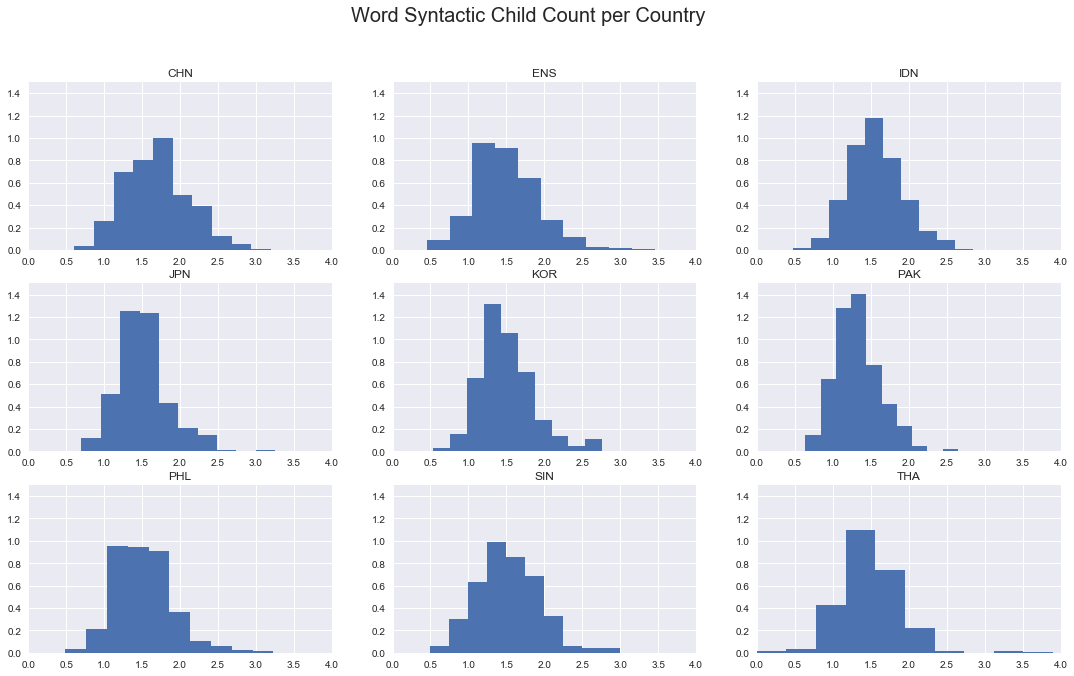

In [37]:
pwk.plot_pattern_country(df_1, 'DT_max_dp_cnts', np.std, 0, 4, 0, 1.5, 'Word Syntactic Child Count per Country')

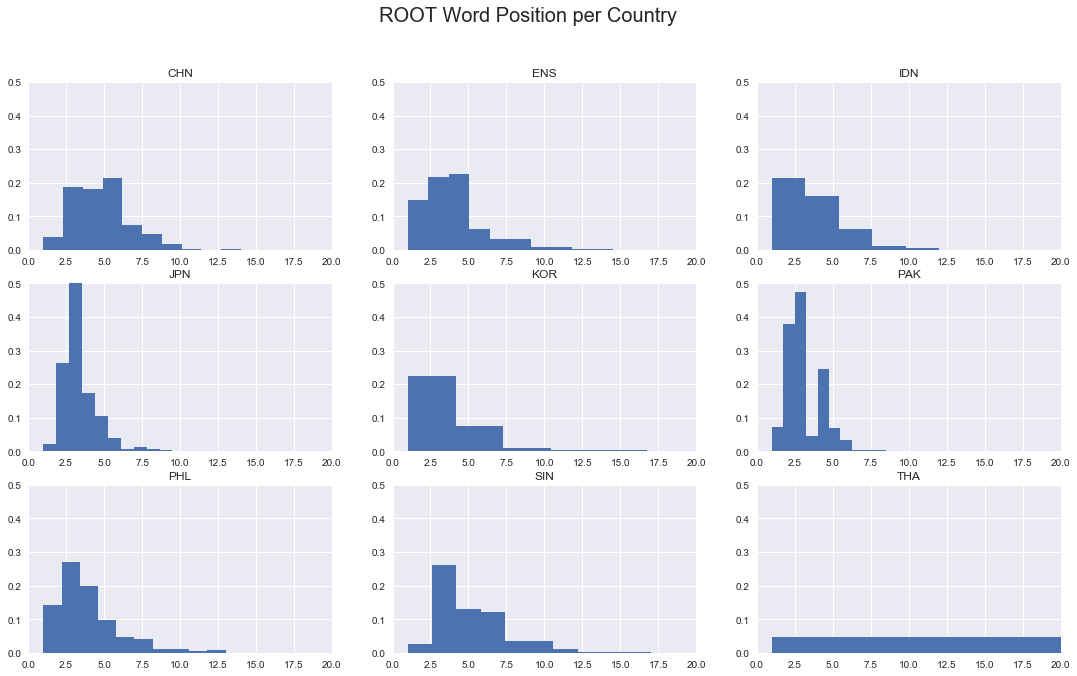

In [38]:
pwk.plot_pattern_country(df_1, 'DT_ROOT_idx', np.median, 0, 20, 0, 0.5, 'ROOT Word Position per Country')

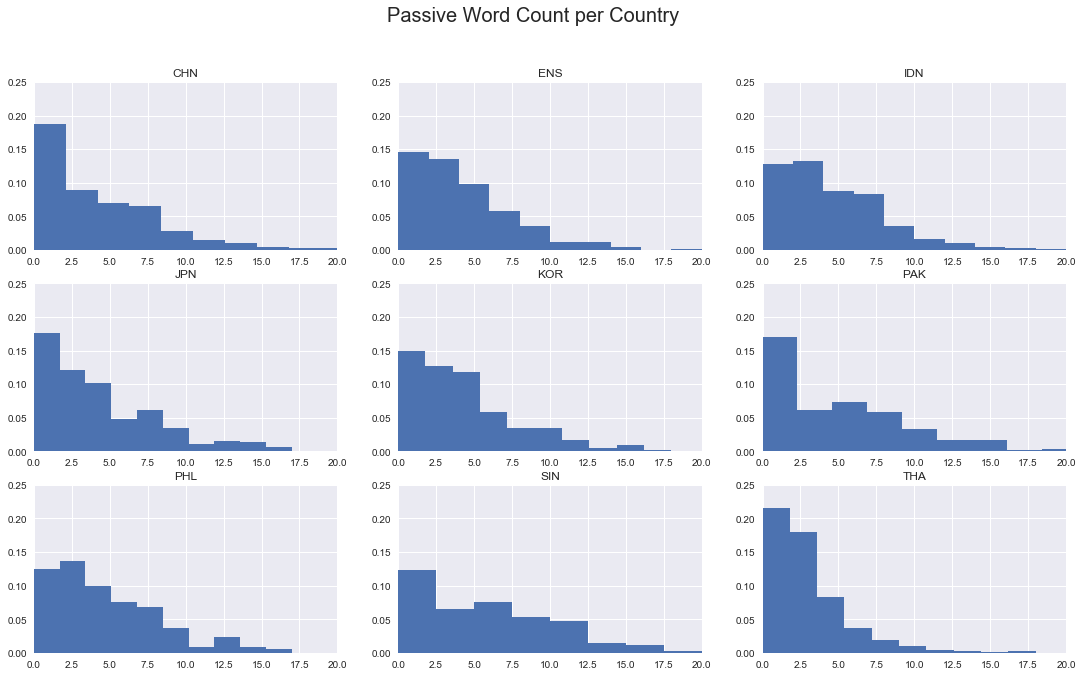

In [39]:
pwk.plot_pattern_country(df_1, 'DT_pass_cnt', np.sum, 0, 20, 0, 0.25, 'Passive Word Count per Country')

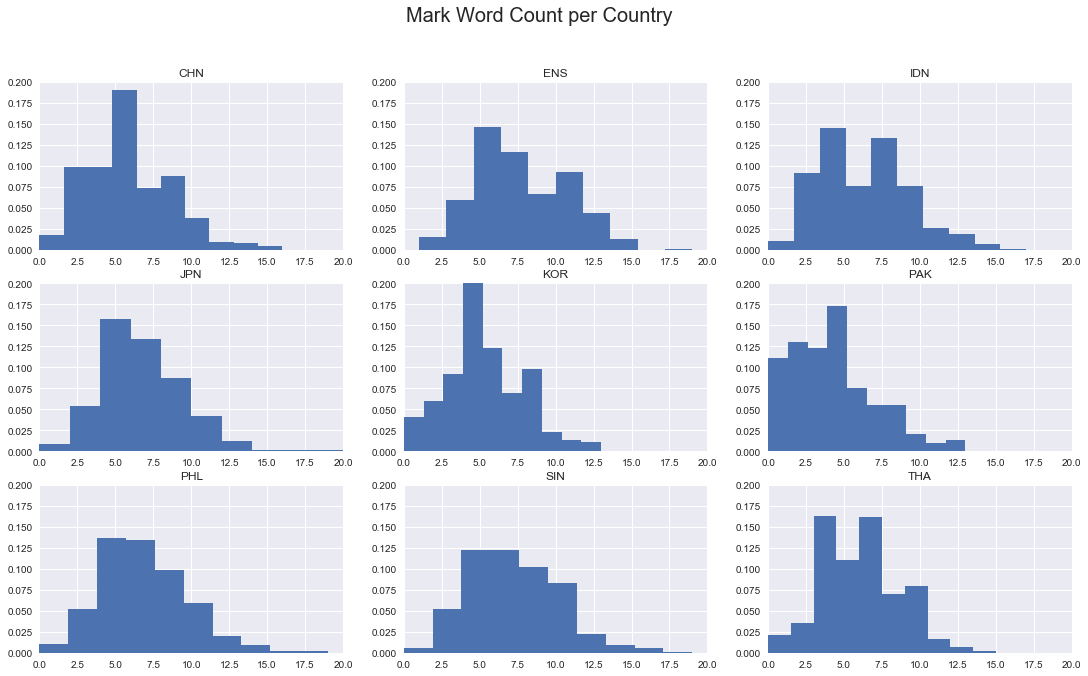

In [40]:
pwk.plot_pattern_country(df_1, 'DT_mark_cnt', np.sum, 0, 20, 0, 0.2, 'Mark Word Count per Country')

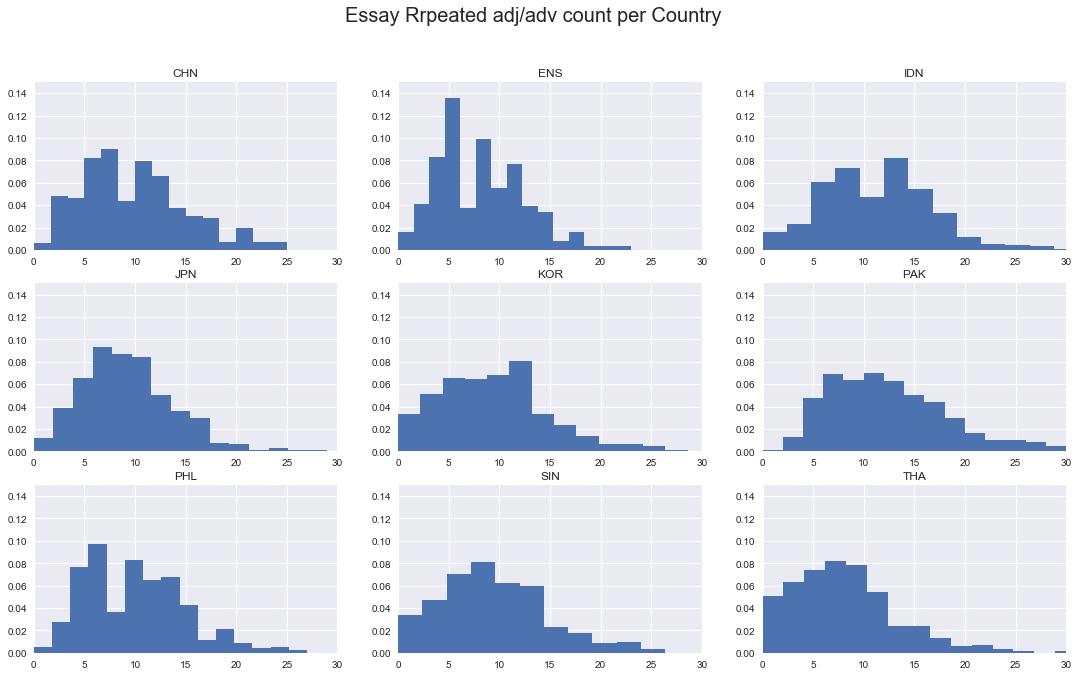

In [41]:
countries = list(df_1.groupby('label').size().index)
fig, axs = plt.subplots(3,3)
for c, ax in zip(countries, axs.flatten()):
    data = df_1[(df_1['label']==c)]['POS_adjv_repeat_sum']
    ax.hist(data, bins=15, normed=1)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 0.15)
    ax.set_title(c)
fig.suptitle('Essay Rrpeated adj/adv count per Country', fontsize=20)
fig.set_size_inches(18.5, 10.5, forward=True)

In [11]:
df_2 = df_1
df_2['DT_max_dp_cnts_std'] = df_2['DT_max_dp_cnts'].apply(lambda x: np.std(x))
df_2['DT_ROOT_idx_mean'] = df_2['DT_ROOT_idx'].apply(lambda x: np.mean(x))
df_2['DT_pass_cnt_sum'] = df_2['DT_pass_cnt'].apply(lambda x: np.sum(x))
df_2['DT_mark_cnt_sum'] = df_2['DT_mark_cnt'].apply(lambda x: np.sum(x))

In [12]:
cols = ['DT_max_dp_cnts_std','DT_ROOT_idx_mean','DT_mark_cnt_sum']
X = df_2[cols]
y = df_2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.202276834594


In [14]:
pipeline_lgr.fit(X_train, y_train)
y_pred = pipeline_lgr.predict(X_test)

In [15]:
pwk.print_confusion_matrix(y_test.values, y_pred)

Predicted,CHN,ENS,JPN,KOR,PAK,PHL,SIN,THA,IDN,All,Accuracy
Actual,,,,,,,,,,,
CHN,38,23,7,10,14,3,6,5,0,106,0.358491
ENS,19,45,11,5,4,3,6,9,0,102,0.441176
IDN,20,22,21,6,24,4,9,1,0,107,0.000000
JPN,17,26,16,7,33,3,1,2,0,105,0.152381
KOR,19,16,10,5,38,2,5,4,0,99,0.050505
PAK,3,13,8,5,63,3,0,1,0,96,0.656250
PHL,22,25,6,8,15,3,8,1,0,88,0.034091
SIN,21,30,2,3,7,7,15,6,0,91,0.164835
THA,14,18,24,3,38,3,3,3,0,106,0.028302


**Interestingly, syntactic features: 'DT_max_dp_cnts_std','DT_ROOT_idx_mean','DT_mark_cnt_sum' seem to make PAK writers very distinguishable. May need to look into Urdu language**

In [45]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=1000))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
print scores.mean()

0.348068414233


In [46]:
pipeline_lgr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.330314380129


**Accuracy increased slightly, but still not great**

**-**

## POS tagging and syntactic tree parsing features

In [47]:
df_2.columns

Index([u'doc_id', u'path', u'author_code', u'essay_content', u'label',
       u'DT_max_dp_cnts', u'DT_archs', u'DT_ROOT_idx', u'DT_pass_cnt',
       u'DT_mark_cnt', u'POS_adjv_body', u'DT_pos', u'DT_pos_join',
       u'DT_archs_join', u'unique_lemma', u'avg_stc_length', u'total_stc',
       u'POS_adjv_repeat', u'POS_adjv_repeat_sum', u'doc2vec_lm_token',
       u'DT_max_dp_cnts_std', u'DT_ROOT_idx_mean', u'DT_pass_cnt_sum',
       u'DT_mark_cnt_sum'],
      dtype='object')

### Generate tf/tf-idf matrix on pos tag body for essays

In [48]:
#df_2.DT_pos_join

In [306]:
X = df_2['DT_pos_join']
y = df_2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [307]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.55305832145


In [308]:
pipeline_lgr.fit(X_train, y_train)
y_pred = pipeline_lgr.predict(X_test)
pwk.print_confusion_matrix(y_test.values, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,53,4,8,13,7,4,2,11,6,108,0.490741
ENS,3,66,1,2,2,4,5,18,4,105,0.628571
IDN,4,3,37,7,4,15,5,4,12,91,0.406593
JPN,5,3,3,68,9,5,1,3,8,105,0.647619
KOR,7,2,10,21,32,4,1,9,11,97,0.329897
PAK,1,3,6,0,0,75,5,0,7,97,0.773196
PHL,9,13,11,6,0,9,42,14,4,108,0.388889
SIN,2,7,1,4,1,2,5,67,2,91,0.736264
THA,5,5,3,7,9,13,5,4,47,98,0.479592


In [242]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', MultinomialNB())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.359698012852


In [51]:
pipeline_rf = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', RandomForestClassifier(n_estimators=1000))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
print scores.mean()

0.537104102691


In [52]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.580437245907


In [309]:
X = df_2['DT_archs_join']
y = df_2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [310]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.570807545565


In [311]:
pipeline_lgr.fit(X_train, y_train)
y_pred = pipeline_lgr.predict(X_test)
pwk.print_confusion_matrix(y_test.values, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,58,3,4,10,8,1,2,7,2,95,0.610526
ENS,6,76,0,2,0,2,6,12,4,108,0.703704
IDN,5,2,46,3,4,7,6,9,11,93,0.494624
JPN,8,1,6,66,14,3,1,3,10,112,0.589286
KOR,11,7,8,16,32,7,3,6,10,100,0.320000
PAK,3,2,5,3,1,85,2,1,5,107,0.794393
PHL,10,8,9,1,3,8,40,11,3,93,0.430108
SIN,6,12,7,0,0,2,13,60,1,101,0.594059
THA,6,2,8,6,7,2,2,2,56,91,0.615385


In [248]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', MultinomialNB())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.388476170165


In [301]:
pipeline_rf = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', RandomForestClassifier(n_estimators=1000))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
print scores.mean()

In [250]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.597941802412


### pos ngram with sentence boundary

In [133]:
n = 4
df_2['DT_insent_pos_ngram'] = df_2['DT_pos'].apply(lambda x: pwk.loop_body(x, n))

In [56]:
X = df_2['DT_insent_pos_ngram']
y = df_2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [57]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, max_features=5000)),
    ('clf', LogisticRegression())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.646561952902


In [59]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=5000)),
    ('clf', MultinomialNB())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.622519046522


In [61]:
pipeline_rf = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
    ('clf', RandomForestClassifier(n_estimators=1000))
])
scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
print scores.mean()

In [62]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=5000)),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.45450663823


**arch ngram with sentence boundary**

In [12]:
n = 3
df_2['DT_insent_arch_ngram'] = df_2['DT_archs'].apply(lambda x: pwk.loop_body(x, n))

In [13]:
X = df_2['DT_insent_arch_ngram']
y = df_2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [14]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, max_features=5000)),
    ('clf', LogisticRegression())#solver='newton-cg', multi_class='multinomial'))
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.68889757809


In [15]:
pipeline_lgr.fit(X_train, y_train)
y_pred = pipeline_lgr.predict(X_test)
pwk.print_confusion_matrix(y_test.values, y_pred)

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,79,2,3,10,4,1,4,3,0,106,0.745283
ENS,2,71,0,0,0,1,5,21,2,102,0.696078
IDN,5,6,61,3,3,8,11,2,8,107,0.570093
JPN,2,1,1,85,10,2,1,0,3,105,0.809524
KOR,11,5,9,12,42,4,5,5,6,99,0.424242
PAK,3,1,3,0,1,83,1,0,4,96,0.864583
PHL,4,3,7,0,3,6,47,17,1,88,0.534091
SIN,3,6,1,0,1,0,6,74,0,91,0.813187
THA,2,4,16,8,4,3,3,2,64,106,0.603774


**-**

In [134]:
df_ens_pak = df_2[(df_2['label']=='ENS')|(df_2['label']=='PAK')]

In [212]:
X = df_ens_pak['DT_insent_pos_ngram']
y = df_ens_pak['label'].values=='PAK'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [213]:
vectorizer = TfidfVectorizer(lowercase=True, max_features=30)
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [214]:
terms = np.array(vectorizer.get_feature_names())

In [215]:
X_test_dtm.shape

(160, 30)

In [216]:
clf = LogisticRegression()
clf.fit(X_train_dtm, y_train)
y_pred = clf.predict(X_test_dtm)
pwk.print_confusion_matrix(y_test, y_pred)

Predicted,False,True,All,Accuracy
Actual,,,,
False,59,13,72,0.819444
True,15,73,88,0.829545
All,74,86,160,0.825000


**The top 10 most representive word orders of PAK**

In [217]:
terms[np.argsort(clf.coef_[0])[::-1][:10]]

array([u'adp_adj_noun_punct', u'noun_verb_det_noun', u'noun_verb_adv_adj',
       u'noun_adp_adj_noun', u'noun_adp_noun_punct', u'det_noun_adp_noun',
       u'verb_adj_noun_punct', u'verb_adj_noun_adp', u'adp_det_noun_punct',
       u'det_adj_noun_punct'], 
      dtype='<U19')

**The top 10 most representive word orders of ENS**

In [156]:
terms[np.argsort(clf.coef_[0])[:10]]

array([u'adj_punct_noun_noun', u'pron_verb_adv_verb', u'adp_det_adj_noun',
       u'det_adj_noun_adp', u'verb_adp_det_noun', u'noun_verb_adv_verb',
       u'verb_det_adj_noun', u'adv_verb_det_noun', u'adj_noun_adp_det',
       u'part_verb_det_noun'], 
      dtype='<U19')

In [209]:
pd.set_option('display.max_colwidth', -1)
#df_ens_pak[df_ens_pak['label']=='PAK'][['essay_content','DT_pos']]

In [198]:
#df_ens_pak['xxx'] = df_ens_pak[['essay_content','DT_pos']].apply(lambda x: [s+p for s,p in zip(spc_nlp(x[0].decode('utf-8')).sents, x[1])])
df_ens_pak['essay_pos'] = df_ens_pak[['essay_content','DT_pos']].apply(lambda x: [s.text+p for s,p in zip(spc_nlp(x['essay_content'].decode('utf-8')).sents, x['DT_pos'])], axis=1)


In [211]:
df_ens_pak[df_ens_pak['label']=='PAK']['essay_pos'].values

array([ [u'\ufeffPart time job means than a permanent job or other than a normal job.ADJ NOUN NOUN NOUN ADP DET ADJ NOUN CCONJ ADJ ADP DET ADJ NOUN PUNCT', u'In our country Pakistan many people use part time job due to low income.ADP ADJ NOUN PROPN ADJ NOUN VERB NOUN NOUN NOUN ADP ADP ADJ NOUN PUNCT', u'Almost fifty percent of Pakistan use part time job.ADV NUM NOUN ADP PROPN VERB NOUN NOUN NOUN PUNCT', u'They want to increase their income.PRON VERB PART VERB ADJ NOUN PUNCT', u'They want extra money to fulfill their desires and needs.PRON VERB ADJ NOUN PART VERB ADJ NOUN CCONJ NOUN PUNCT', u'More money is needed.ADJ NOUN VERB VERB PUNCT', u"So, that's why part time job gives many benefits to a person.ADV PUNCT DET VERB ADV NOUN NOUN NOUN VERB ADJ NOUN ADP DET NOUN PUNCT", u'Dearness also cause if part time job.PROPN ADV VERB ADP NOUN NOUN NOUN PUNCT', u'Some people use part time job for leisure time consume.DET NOUN VERB NOUN NOUN NOUN ADP NOUN NOUN NOUN PUNCT', u'Some people use part 

**-**

**Interestingly, using trigram word archs, the accuracy of identifying Pakistan peaked among all countries**

In [66]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=5000)),
    ('clf', MultinomialNB())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.641794234908


In [67]:
# pipeline_rf = Pipeline([
#     ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=100)),
#     ('clf', RandomForestClassifier(n_estimators=1000))
# ])
# scores = cross_val_score(pipeline_rf, X_train, y_train, cv=11)
# print scores.mean()

In [68]:
pipeline_lgr = Pipeline([
    ('vect', TfidfVectorizer(lowercase=True, ngram_range=(2,2), max_features=5000)),
    ('clf', LinearSVC())
])
scores = cross_val_score(pipeline_lgr, X_train, y_train, cv=11, scoring='accuracy')
print scores.mean()

0.64688395507


**-**

## Doc2Vec matrix featurs

#### Vectorize: essay_content, DT_insent_arch_ngram, DT_insent_pos_ngram, DT_arch_join, DT_pos_join

In [133]:
n = 5
df_2['DT_insent_arch_ngram'] = df_2['DT_archs'].apply(lambda x: pwk.loop_body(x, n))

In [80]:
n = 5
df_2['DT_insent_pos_ngram'] = df_2['DT_pos'].apply(lambda x: pwk.loop_body(x, n))

In [134]:
cond = (df_2['label']!='ENS')|(df_2['label']!='CHN')|\
(df_2['label']!='JPN')|(df_2['label']!='KOR')|(df_2['label']!='THA')
df_input = df_2[cond]

In [135]:
cv_data, test_data = train_test_split(df_input, test_size=0.1)

**Cross validation using different classifiers**

In [164]:
import itertools

ngram_range = [i for i in range(2,11)]
window_range = [i for i in range(1,6)]

combs = list(itertools.product(ngram_range, window_range))

In [155]:
col = 'essay_content'
# essay_content, DT_insent_arch_ngram, DT_insent_pos_ngram, DT_arch_join, DT_pos_join

**Use all possible combinations of ngram and window size to see performance differences**

In [ ]:
col = 'essay_content'
for w in range(1,10):
    print ('window size: ', w)
    cond = (df_2['label']!='ENS')|(df_2['label']!='CHN')|\
    (df_2['label']!='JPN')|(df_2['label']!='KOR')|(df_2['label']!='THA')
    df_input = df_2[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, w, 100, clf, literal=True))

In [ ]:
col = 'DT_arch_join'
for w in range(1,10):
    print ('window size: ', w)
    cond = (df_2['label']!='ENS')|(df_2['label']!='CHN')|\
    (df_2['label']!='JPN')|(df_2['label']!='KOR')|(df_2['label']!='THA')
    df_input = df_2[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, w, 100, clf, literal=True))

In [ ]:
col = 'DT_pos_join'
for w in range(1,10):
    print ('window size: ', w)
    cond = (df_2['label']!='ENS')|(df_2['label']!='CHN')|\
    (df_2['label']!='JPN')|(df_2['label']!='KOR')|(df_2['label']!='THA')
    df_input = df_2[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, w, 100, clf, literal=True))

In [ ]:
col = 'DT_insent_pos_ngram'
for ng in range(2, 21):
    print ('ngram_n: ', ng)
    #print ('window size: ', c[1])
    print ('window size: ', str(1))
    n = ng
    df_2['DT_insent_pos_ngram'] = df_2['DT_pos'].apply(lambda x: pwk.loop_body(x, n))
    cond = (df_2['label']!='ENS')|(df_2['label']!='CHN')|\
    (df_2['label']!='JPN')|(df_2['label']!='KOR')|(df_2['label']!='THA')
    df_input = df_2[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, 1, 100, clf, literal=False))

In [ ]:
col = 'DT_insent_arch_ngram'
for ng in range(2, 21):
    print ('ngram_n: ', ng)
    #print ('window size: ', c[1])
    print ('window size: ', str(1))
    n = ng
    df_2['DT_insent_arch_ngram'] = df_2['DT_archs'].apply(lambda x: pwk.loop_body(x, n))
    cond = (df_2['label']!='ENS')|(df_2['label']!='CHN')|\
    (df_2['label']!='JPN')|(df_2['label']!='KOR')|(df_2['label']!='THA')
    df_input = df_2[cond]
    cv_data, test_data = train_test_split(df_input, test_size=0.1)
    clf = LogisticRegression()
    print (pwk.k_fold_doc2vec_clf(cv_data, col, 1, 100, clf, literal=False))

**Pick the best hyper patameter and model for final train and test**

In [95]:
train_data, test_data = train_test_split(df_2, train_size=0.7)

col = 'essay_content'
train_docs = pwk.tag_docs(train_data, col, literal=True)
test_docs = pwk.tag_docs(test_data, col, literal=True)
model = pwk.train_doc2vec_model(train_docs, 2, 100)
    
y_train, X_train = pwk.vec_for_learning(model, train_docs)
y_test, X_test = pwk.vec_for_learning(model, test_docs)
    
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [158]:
print accuracy_score(y_test, y_pred)

0.788


In [104]:
pwk.print_confusion_matrix(y_test, y_pred)#['All']['All']

Predicted,CHN,ENS,IDN,JPN,KOR,PAK,PHL,SIN,THA,All,Accuracy
Actual,,,,,,,,,,,
CHN,225,7,4,10,15,7,3,0,7,278,0.809353
ENS,0,222,3,2,10,3,9,27,7,283,0.784452
IDN,3,13,200,9,10,9,17,7,12,280,0.714286
JPN,15,7,6,221,17,6,1,1,3,277,0.797834
KOR,17,5,5,22,179,8,12,5,25,278,0.643885
PAK,9,3,1,0,1,242,2,1,1,260,0.930769
PHL,4,26,11,2,12,12,201,16,8,292,0.688356
SIN,6,22,1,2,6,2,22,224,0,285,0.785965
THA,9,10,17,14,20,3,16,7,191,287,0.665505


## Feature Selection

**Combining all features**

## Gridsearch on Doc2Vec feature (done on AWS EC2)

In [116]:
# train_data, test_data = train_test_split(df_2, test_size=0.7)

# col = 'essay_content'
# train_docs = pwk.tag_docs(train_data, col, literal=True)
# test_docs = pwk.tag_docs(test_data, col, literal=True)
# model = pwk.train_doc2vec_model(train_docs, 2, 100)

# y_train, X_train = pwk.vec_for_learning(model, train_docs)
# y_test, X_test = pwk.vec_for_learning(model, test_docs)

### Logistic Regression


In [117]:
# model = ('lrclf', LogisticRegression())

# steps = [
#     model
# ]

# grid = {'lrclf__C':[0.001,0.01,0.1,1,10],
#         'lrclf__penalty':['l1','l2']
# }

# pipeline = Pipeline(steps)
# gridsearch = GridSearchCV(pipeline,
#                           grid,
#                           scoring='accuracy',
#                           cv=5,
#                           verbose=1,
#                           n_jobs=-1)

# gridsearch.fit(X_train, y_train)
# best_model = gridsearch.best_estimator_
# print (best_model)

In [118]:
# clf = LogisticRegression(penalty='l2', C=1)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [119]:
# pwk.print_confusion_matrix(y_test, y_pred)

### Random Forest

In [121]:
# model = ('rfclf', RandomForestClassifier())

# steps = [
#     model
# ]
# random_forest_grid = {'rfclf__max_depth': [None, 2, 3, 4],
#                       'rfclf__max_features': ['sqrt', 'log2', None],
#                       'rfclf__min_samples_split': [2, 3, 4],
#                       'rfclf__min_samples_leaf': [1, 2, 3,4],
#                       'rfclf__criterion': ['gini', 'entropy'],
#                       'rfclf__bootstrap': [True, False],
#                       'rfclf__n_estimators': [500]}

# pipeline = Pipeline(steps)
# gridsearch = GridSearchCV(pipeline,
#                          random_forest_grid,
#                          n_jobs=-1,
#                          cv=5,
#                          verbose=1,
#                          scoring='accuracy')

# gridsearch.fit(X_train, y_train)
# best_rf_model = gridsearch.best_estimator_
# print (best_rf_model)

In [122]:
# clf = RandomForestClassifier(XXX)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [123]:
# pwk.print_confusion_matrix(y_test, y_pred)

### Gradient Boosting

In [124]:
# gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02],
#                           'loss': ['deviance', 'exponential'],
#                           'max_depth': [2, 4],
#                           'min_samples_leaf': [1, 2, 5],
#                           'max_features': [1.0, 0.5],
#                           'n_estimators': [500, 1000, 3000],
#                           'random_state': [1]}

# gbclf_gridsearch = GridSearchCV(GradientBoostingClassifier(), 
#                               gradient_boosting_grid,
#                               cv=5,
#                               verbose=5,
#                               n_jobs=-1,
#                               scoring='accuracy')
# gbclf_gridsearch.fit(X_train, y_train)
# print ("best parameters:", gbclf_gridsearch.best_params_)

# best_gbclf_model = gbclf_gridsearch.best_estimator_
# print best_gbclf_model

In [ ]:
# clf = GradientBoostingClassifier(n_estimators=XXX)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [125]:
# pwk.print_confusion_matrix(y_test, y_pred)